<a href="https://colab.research.google.com/github/get2okey/Project-Echo/blob/main/optimised_engine_pipeline_%5BOE%5D_BVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimised Engine Pipeline

The notebook provide an optimised version of the generic engine pipeline.

This notebook aims to enhance the engine pipeline through:

(1) Be compatible with Lambda Stack (https://lambdalabs.com/lambda-stack-deep-learning-software) to enable containisation, cloud and cross-platform development

(2) Upgrade tensorflow from 2.10 to 2.11

(3) Enable execution on linux and Windows 11 WSL2 environments

(3) Minimise library dependencies

(4) Solve the parallel pipeline execution issues inherent in the generic_engine_pipeline for faster execution of the pipeline

Author: akudilczak

In [2]:
!pip install diskcache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.3 MB/s eta 0:00:00


In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.1 MB/s eta 0:00:00


In [4]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0


In [5]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 3.3 MB/s eta 0:00:00


In [6]:
!pip install keras==2.10
!pip install tensorflow==2.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.10.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [7]:
# !pip install google-cloud-storage

In [8]:
# # Install the Google Cloud SDK (gcloud command-line tool)
# !curl https://sdk.cloud.google.com | bash

# # Restart the Colab runtime to apply changes
# import os
# os.kill(os.getpid(), 9)

In [9]:
# !gcloud auth login
# !gcloud config set project sit-23t1-project-echo-25288b9


In [10]:
########################################################################################
# library imports
########################################################################################

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# environment settings
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# generic libraries
from platform import python_version
import functools
from functools import lru_cache
import diskcache as dc
import hashlib
import numpy as np
import datetime
import random
import io
import matplotlib.pyplot as plt

# tensor flow / keras related libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
from keras.utils import dataset_utils
import tensorflow_io as tfio

# Your code using tfio.audio.resample

# image processing related libraries
import librosa

import csv

# audio processing libraries
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

Python Version           :  3.10.12
TensorFlow Version       :  2.10.0
Librosa Version          :  0.10.1
Audiomentations Version  :  0.33.0


## System Configuration

The following code sets up the pipeline with configuration options.

The key is to set the audio data directory to the root directory containing the folders with raw audio files.

This expects the folders names to be the species names.  

In [42]:
########################################################################################
# system constants
########################################################################################

SC = {


    'CACHE_DIRETORY': "/content/drive/MyDrive/bird_cache",
    'AUDIO_DATA_DIRECTORY': "/content/drive/MyDrive/Training data",

    'AUDIO_CLIP_DURATION': 5, # seconds
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 48000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 20,
    'CLASSIFIER_BATCH_SIZE': 16,
    'MAX_EPOCHS': 5000,
}

SC

{'CACHE_DIRETORY': '/content/drive/MyDrive/bird_cache',
 'AUDIO_DATA_DIRECTORY': '/content/drive/MyDrive/Training data',
 'AUDIO_CLIP_DURATION': 5,
 'AUDIO_NFFT': 2048,
 'AUDIO_WINDOW': None,
 'AUDIO_STRIDE': 200,
 'AUDIO_SAMPLE_RATE': 48000,
 'AUDIO_MELS': 260,
 'AUDIO_FMIN': 20,
 'AUDIO_FMAX': 13000,
 'AUDIO_TOP_DB': 80,
 'MODEL_INPUT_IMAGE_WIDTH': 260,
 'MODEL_INPUT_IMAGE_HEIGHT': 260,
 'MODEL_INPUT_IMAGE_CHANNELS': 3,
 'USE_DISK_CACHE': True,
 'SAMPLE_VARIANTS': 20,
 'CLASSIFIER_BATCH_SIZE': 16,
 'MAX_EPOCHS': 5000}

In [43]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)

# enforce max 5GB memory on GPU for this notebook if you have a small GPU
# enforce_memory_limit(5120)

# Disk Caching

The following code creates a disk cache.  You will need lots of space (20 GB+) if you create large melspectrograms.

The caching works by serialising a function call signature and hashing it into a key.  This key is used to store the result of the function call.

This allows the a result from the cache to be utilised instead of calling the function, which means the entire data processing pipeline can be cached if used correctly.

This works best when the function being cached is idempotent.  There may be circumstances where it doesn't matter.  Be careful with using this cache as you may get unexpected results.

In [44]:
########################################################################################
# Create a DiskCache instance
# This cache will allow us store intermediate function results to speed up the
# data processing pipeline
########################################################################################
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9)


########################################################################################
# a helper function to create a hash key from a function signature and arguments
########################################################################################
def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func

# Loading the files into a Tensorflow dataset structure for model training

This initial code loads only the filenames.  The filenames are then split into train, validation and test datasets.  This is designed deliberately this way to conserve runtime memory.

Subsequent downstream loading of the file content occurs as part of the data pipeline transformation 'map' function.  See below.

In [45]:
########################################################################################
# these helper functions load the audio data into a 'dataset' using only paths
# just dealing with paths at this early stage means the entire dataset can be shuffled in
# memory and split before loading the actual audio data into memory
########################################################################################
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels,
        'categorical',
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=True,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))

    # Calculate the size of the dataset
    dataset_size = len(dataset)

    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds, class_names

In [46]:
# create the dataset

train_ds, val_ds, test_ds, class_names = create_datasets(SC['AUDIO_DATA_DIRECTORY'],train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Found 718 files belonging to 1 classes.
Class names:  ['Acanthagenys rufogularis']
Training   dataset length: 574
Validation dataset length: 136
Test       dataset length: 8


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# show what the pipeline looks like at this stage
for item in train_ds.take(10):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Training data/Acanthagenys rufogularis/region_142.000-144.000.mp3'>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Training data/Acanthagenys rufogularis/region_278.900-280.650.mp3'>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Training data/Acanthagenys rufogularis/region_108.550-110.550.mp3'>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Training data/Acanthagenys rufogularis/region_74.000-76.000.mp3'>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Training data/Acanthagenys rufogularis/region_537.050-539.050.mp3'>, <tf.Tensor: shape=(1,

## Loading the audio files

In [48]:
# enable this cache if using large audio files, and lots of available RAM
def python_load_and_decode_file(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):

        tmp_audio_t = None

        with open(sample, 'rb') as file:

            # Load the audio data with librosa
            tmp_audio_t, _ = librosa.load(file, sr=SC['AUDIO_SAMPLE_RATE'])

            # cast and keep right channel only
            if tmp_audio_t.ndim == 2 and tmp_audio_t.shape[0] == 2:
                tmp_audio_t = tmp_audio_t[1, :]

            # cast and keep right channel only
            tmp_audio_t = tmp_audio_t.astype(np.float32)

            assert(tmp_audio_t is not None)
            assert(isinstance(tmp_audio_t, np.ndarray))

        sample = tmp_audio_t

    else:
        sample = cache[cache_key.decode('utf-8')]

    return sample, label, variant, cache_key, cache_found

# Sampling the audio files

The function loads and decodes an audio file from the given path, calculates the audio file's duration in seconds, and then extracts a random subsection of the specified duration (in seconds) from the audio. If the audio duration is shorter than the specified duration, the function pads the subsection with silence to meet the required length. The resulting subsection is returned as a tensor.

In [49]:
def tensorflow_load_random_subsection(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        duration_secs = SC['AUDIO_CLIP_DURATION']

        # Determine the audio file's duration in seconds
        audio_duration_secs = tf.shape(sample)[0] / SC['AUDIO_SAMPLE_RATE']

        if audio_duration_secs>duration_secs:

            # Calculate the starting point of the 5-second subsection
            max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
            start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)

            start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)

            # Load the 5-second subsection
            end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)

            subsection = sample[start_index : end_index]

        else:
            # Pad the subsection with silence if it's shorter than 5 seconds
            padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(sample)[0]
            padding = tf.zeros([padding_length], dtype=sample.dtype)
            subsection = tf.concat([sample, padding], axis=0)

        sample = subsection

    return sample, label, variant, cache_key, cache_found

# Audio augmentations

The following code applies a sequence of augmentations to the audio signal.

A probability of applying the augmentation is used to ensure the augmentation isn't applied every sample.

This means there will be some samples that go straight through with no augmentations and a small probability that in fact all augmentations will be applied.

In [50]:
# Audio augmentation pipeline
def python_audio_augmentations(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        # See https://github.com/iver56/audiomentations for more options
        augmentations = Compose([
            # Add Gaussian noise with a random amplitude to the audio
            # This can help the model generalize to real-world scenarios where noise is present
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

            # Time-stretch the audio without changing its pitch
            # This can help the model become invariant to small changes in the speed of the audio
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

            # Shift the pitch of the audio within a range of semitones
            # This can help the model generalize to variations in pitch that may occur in real-world scenarios
            PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

            # Shift the audio in time by a random fraction
            # This can help the model become invariant to the position of important features in the audio
  #          Shift(min_fraction=-0.5, max_fraction=0.5, p=0.2),
        ])

        # apply audio augmentation to the clip
        # note: this augmentation is NOT applied in the test and validation pipelines
        sample = augmentations(samples=sample, sample_rate=SC['AUDIO_SAMPLE_RATE'])

    return sample, label, variant, cache_key, cache_found

# Image Augmentations

After the melspectrogram pipeline is executed, a 2D image is created of the signal energy at frequence/time points.

This image is augmented by applying the function below.  In this example a random rotation of between -2 and 2 degrees is applied every time.

In [51]:
# image augmentation pipeline
def tensorflow_image_augmentations(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        # random rotation -2 deg to 2 deg
        degrees = tf.random.uniform(shape=(1,), minval=-2, maxval=2)

        # convert the angle in degree to radians
        radians = degrees * 0.017453292519943295

        # rotate the image
        sample = tfa.image.rotate(sample, radians, interpolation='bilinear')

    return sample, label, variant, cache_key, cache_found

In [52]:
# this function takes the audio_clip and generates a melspectrogram representation
# the size of the image will always be the same as the length of audio is fixed and the
# various parameters such as AUDIO_STRIDE that impact image size are also fixed.
def python_dataset_melspectro_pipeline(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        # Compute the mel-spectrogram
        image = librosa.feature.melspectrogram(
            y=sample,
            sr=SC['AUDIO_SAMPLE_RATE'],
            n_fft=SC['AUDIO_NFFT'],
            hop_length=SC['AUDIO_STRIDE'],
            n_mels=SC['AUDIO_MELS'],
            fmin=SC['AUDIO_FMIN'],
            fmax=SC['AUDIO_FMAX'],
            win_length=SC['AUDIO_WINDOW'])

        # Optionally convert the mel-spectrogram to decibel scale
        image = librosa.power_to_db(
            image,
            top_db=SC['AUDIO_TOP_DB'],
            ref=1.0)

        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])

        # swap axis and clip to expected samples to avoid rounding errors
        image = np.moveaxis(image, 1, 0)
        sample = image[0:expected_clip_samples,:]

    return sample, label, variant, cache_key, cache_found


def tensorflow_reshape_image_pipeline(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        # reshape into standard 3 channels to add the color channel
        image = tf.expand_dims(sample, -1)

        # most pre-trained model classifer model expects 3 color channels
        image = tf.repeat(image, SC['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)

        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])

        # calculate the image shape and ensure it is correct
        image = tf.ensure_shape(image, [expected_clip_samples, SC['AUDIO_MELS'], SC['MODEL_INPUT_IMAGE_CHANNELS']])

        # note here a high quality LANCZOS5 is applied to resize the image to match model image input size
        image = tf.image.resize(image, (SC['MODEL_INPUT_IMAGE_WIDTH'],SC['MODEL_INPUT_IMAGE_HEIGHT']),
                                method=tf.image.ResizeMethod.LANCZOS5)

        # rescale to range [0,1]
        image = image - tf.reduce_min(image)
        sample = image / (tf.reduce_max(image)+0.0000001)

    return sample, label, variant, cache_key, cache_found

# Individual dataset pipelines

The dataset is split into different pipeline function as that augmentations would be applied to the training data only.

In [53]:
def tensorflow_add_variant_and_cache(path, label):
    variant     = tf.random.uniform(shape=(), minval=0, maxval=SC['SAMPLE_VARIANTS'], dtype=tf.int32)
    sample      = path
    cache_key   = b'no key'
    cache_found = np.int32(0)
    return sample, label, variant, cache_key, cache_found

def tensorflow_drop_variant_and_cache(sample, label, variant, cache_key, cache_found):
    return sample, label

def tensorflow_output_shape_setter(sample, label, variant, cache_key, cache_found):
    sample.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([len(class_names),])
    return sample, label, variant, cache_key, cache_found

In [54]:
def python_fuction_wrapper(pipeline_fn, out_types, sample, label, variant, cache_key, cache_found):

    # Use a lambda function to pass two arguments to the function
    sample, label, variant, cache_key, cache_found = tf.numpy_function(
        func=lambda v1,v2,v3,v4,v5: pipeline_fn(v1,v2,v3,v4,v5),
        inp=(sample, label, variant, cache_key, cache_found),
        Tout=out_types)

    return sample, label, variant, cache_key, cache_found

In [55]:
def python_disk_cache_start(sample, label, variant, cache_key, cache_found):

    cache_key   = b'no key'
    cache_found = np.int32(0)

    if SC['USE_DISK_CACHE']:
        _,cache_key,_ = create_function_key(python_disk_cache_start, sample, label, variant)
        if cache_key in cache:
            #print(f'found {cache_key} in cache')
            cache_found = np.int32(1)
        else:
            pass
            #print(f'{cache_key} not found in cache')

    return sample, label, variant, cache_key, cache_found

def python_disk_cache_end(sample, label, variant, cache_key, cache_found):
    cache_key = cache_key.decode('utf-8')
    if SC['USE_DISK_CACHE']:
        # if it was not found in the cache at the start, then populate with what we built
        # during the pipeline execution
        if cache_found == np.int32(0):
            #print(f'adding {cache_key} to cache')
            cache[cache_key] = sample
        #else:
        #    sample = cache[cache_key]

    return sample, label, variant, cache_key, cache_found

In [56]:
########################################################################################
# Create the datasets necessary for training a classification model
# Note: python and tensorflow functions are treated differently in the tensorflow
# pipeline.  Each python function needs to be wrapped.
# this is why each pipeline function starts with python_ or tensorflow_ to make it clear
########################################################################################

# Get the length of the training dataset
len_train_ds = len(train_ds)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)

# Create the training dataset pipeline
train_dataset = (train_ds
                 .shuffle(len_train_ds)
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

In [57]:
# Create the validation dataset pipeline
validation_dataset = (val_ds
                    .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

In [58]:
# Create the test dataset pipeline
test_dataset = (test_ds
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

# Data Pipeline Inspection

The following shows 1 batch of training data to provide a visual guide as to whether the data pipeline is functioning as expected.

It is important to observe in the ground truth labels that the classes are random - indicating that the pipeline shuffle function is working as expected.

 sample info: (16, 260, 260, 3), 
 label info: (16, 1) 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


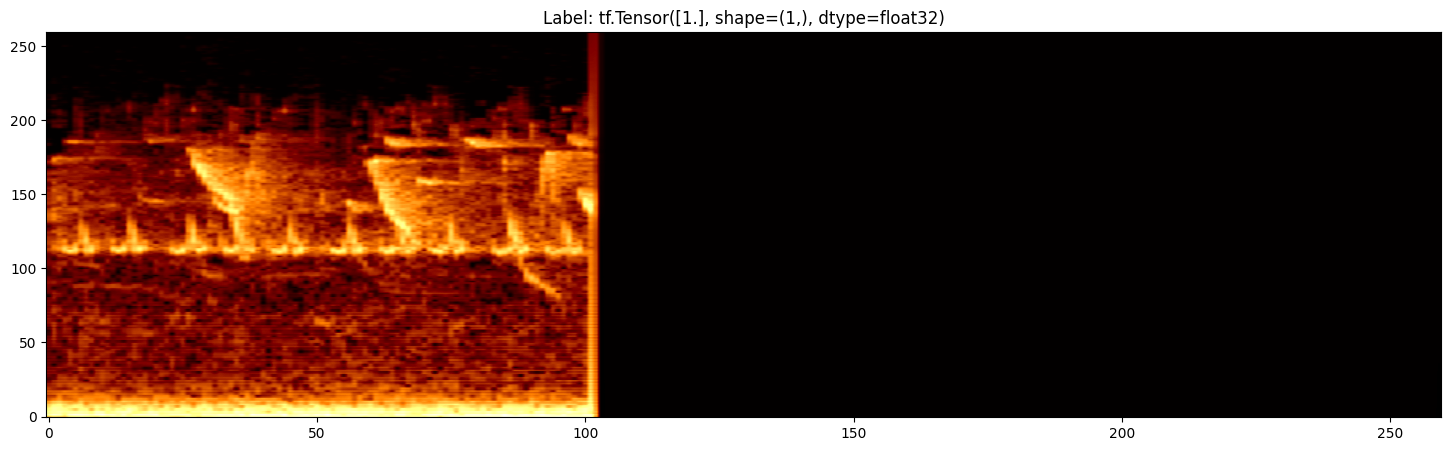

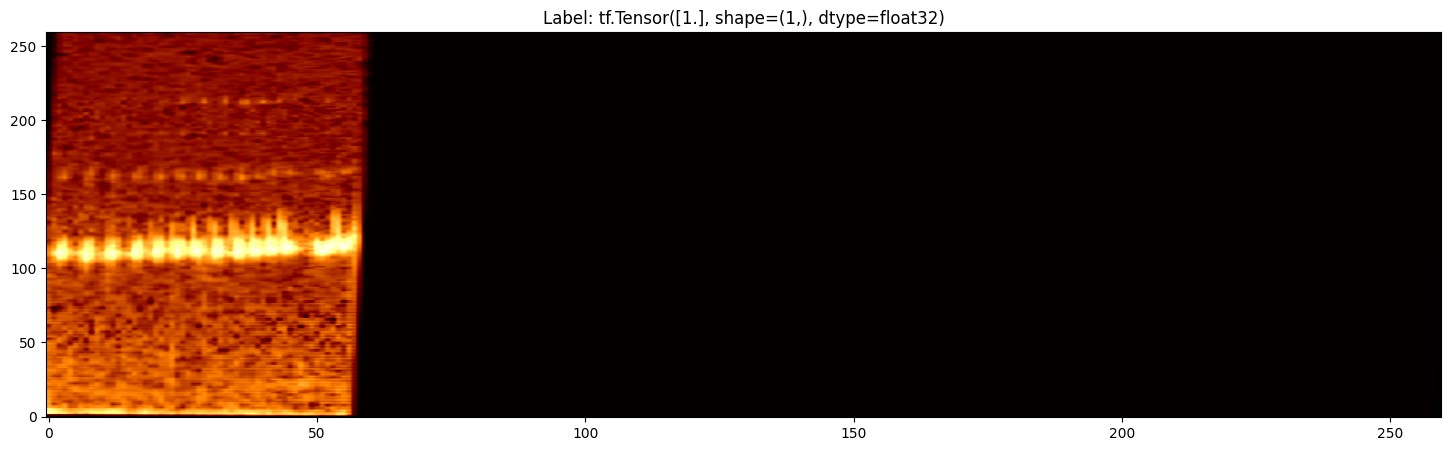

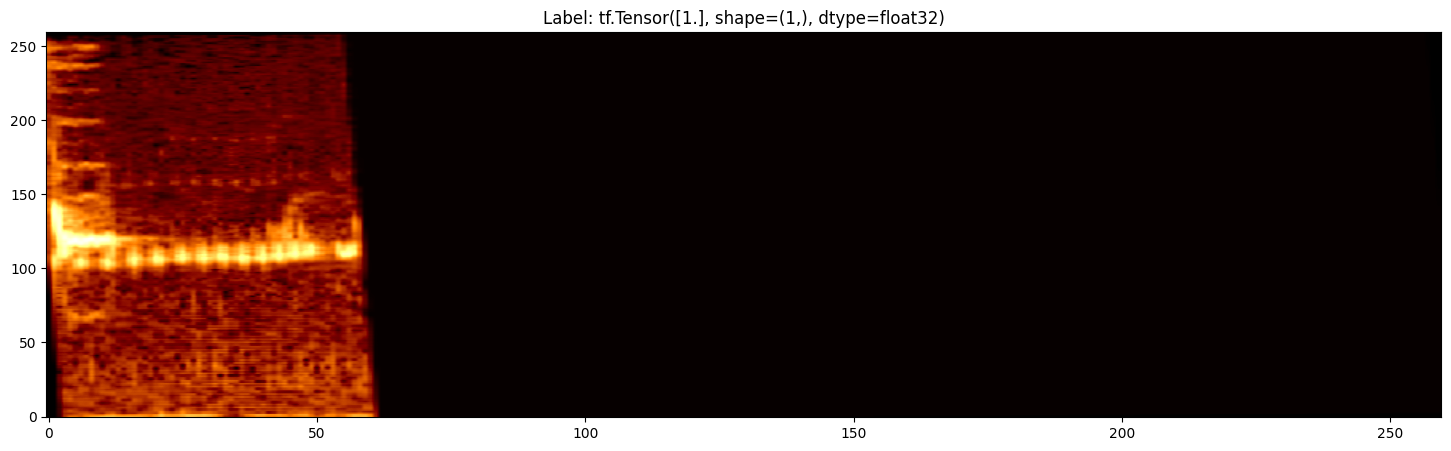

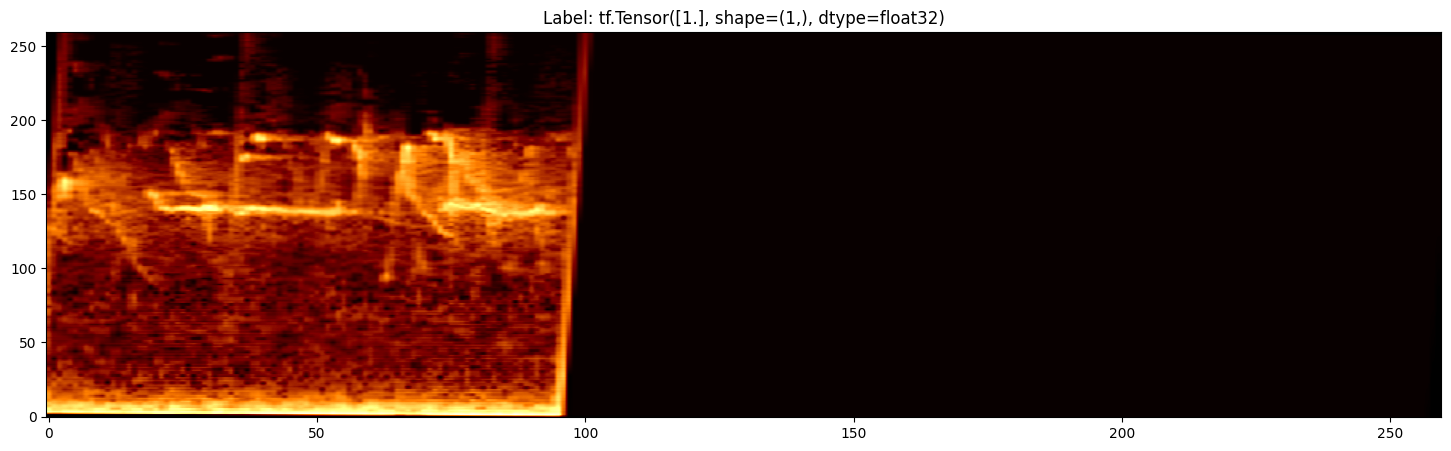

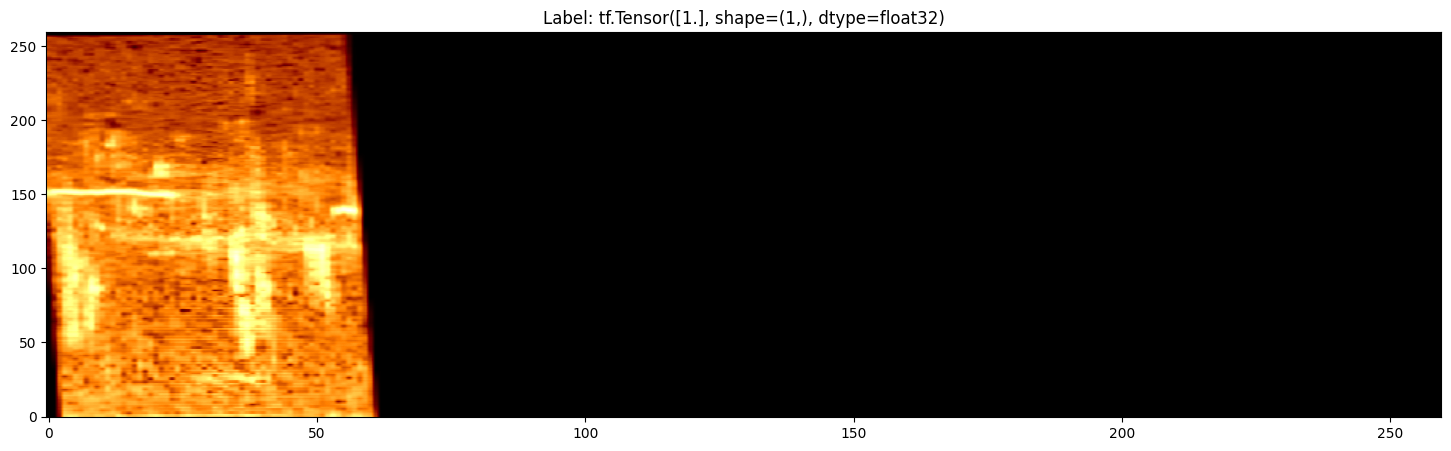

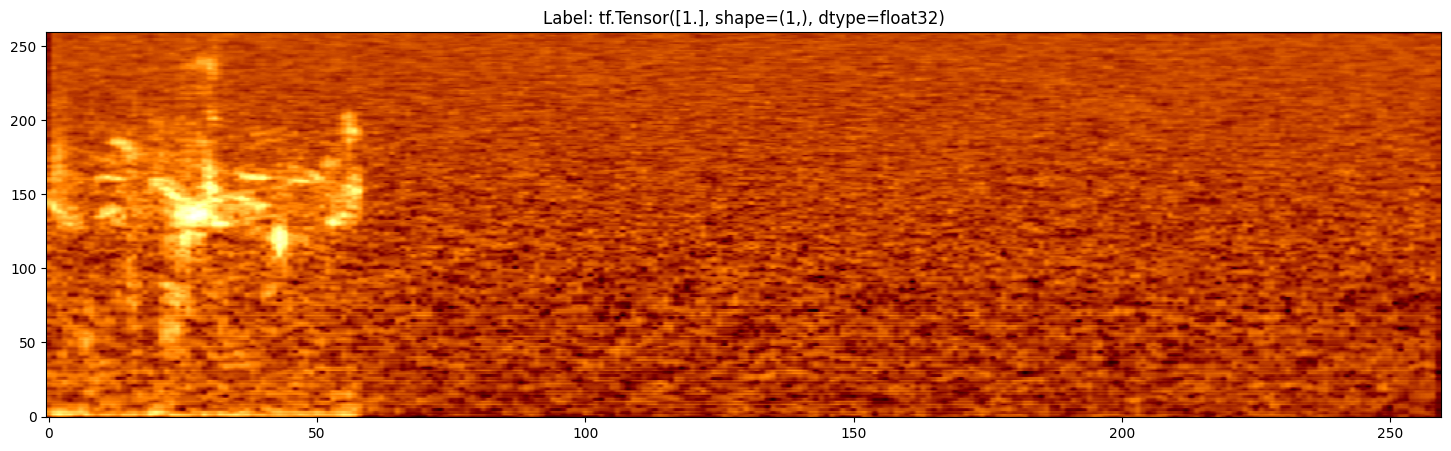

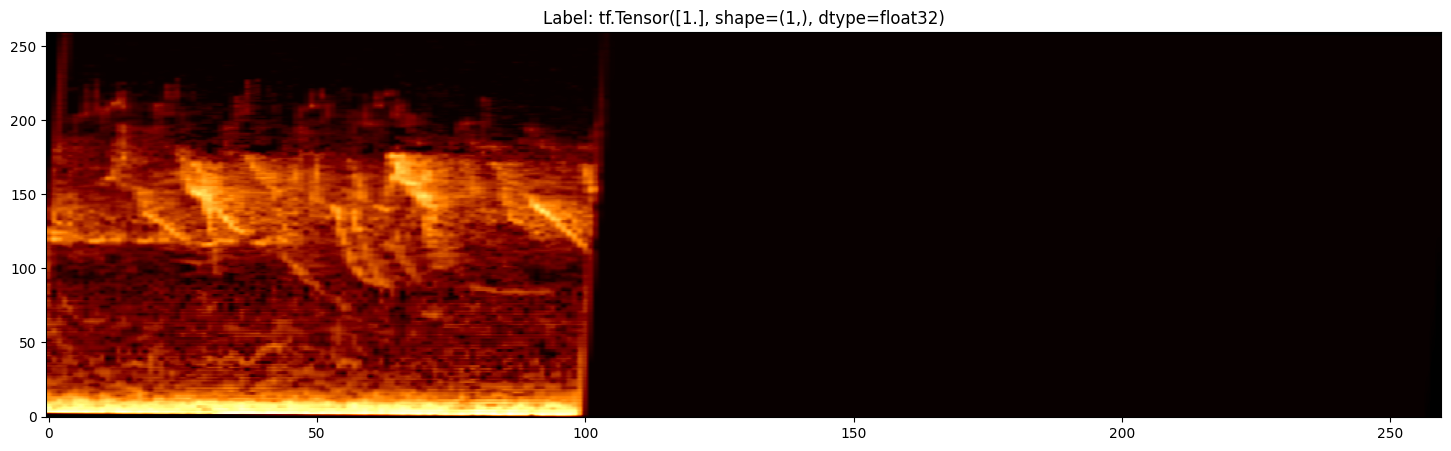

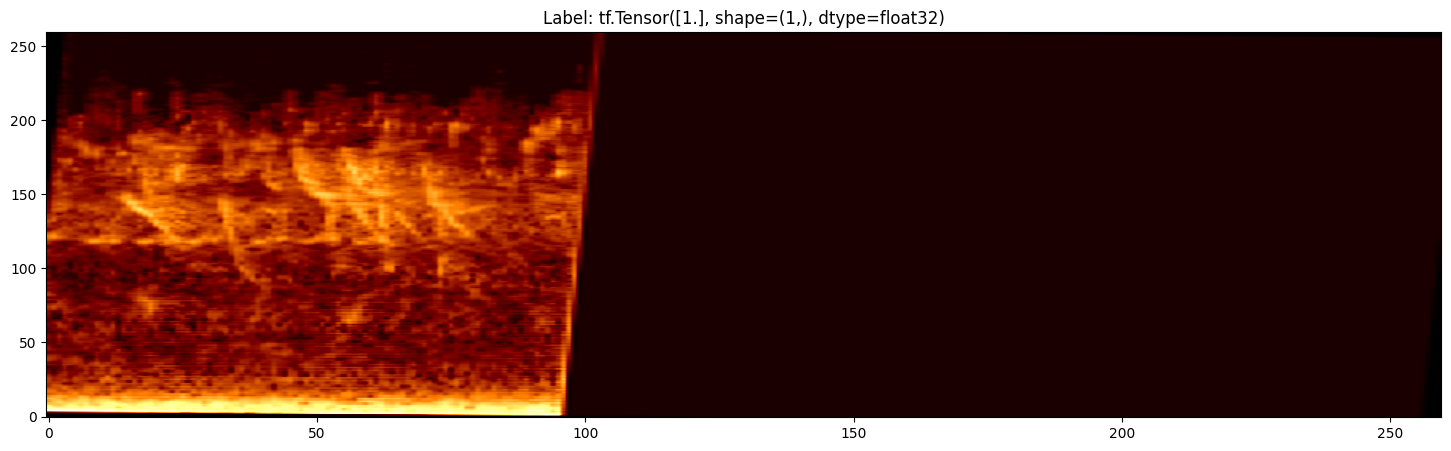

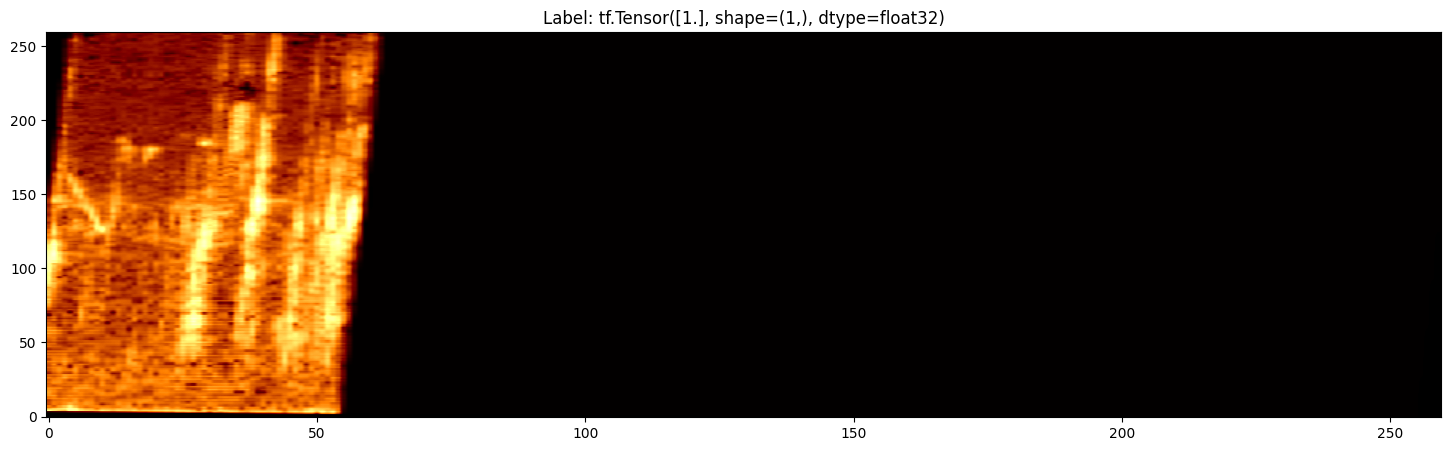

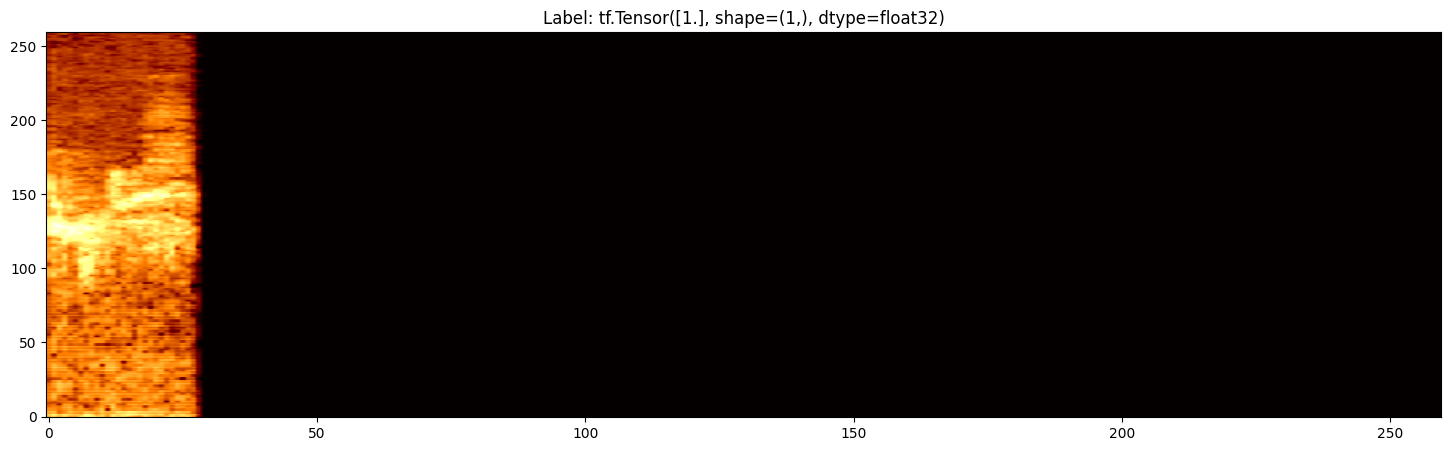

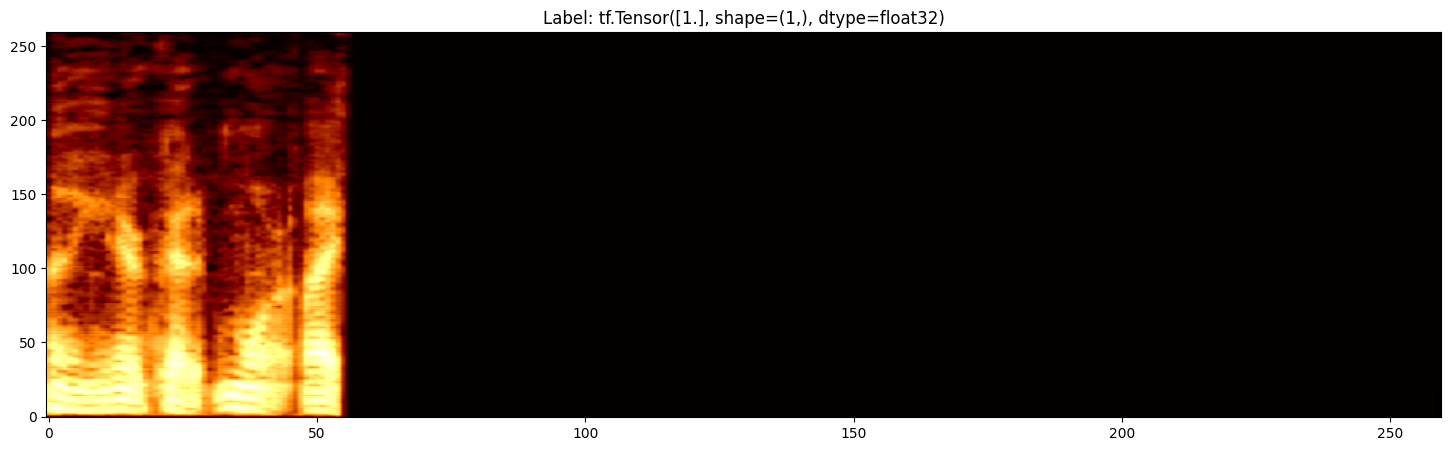

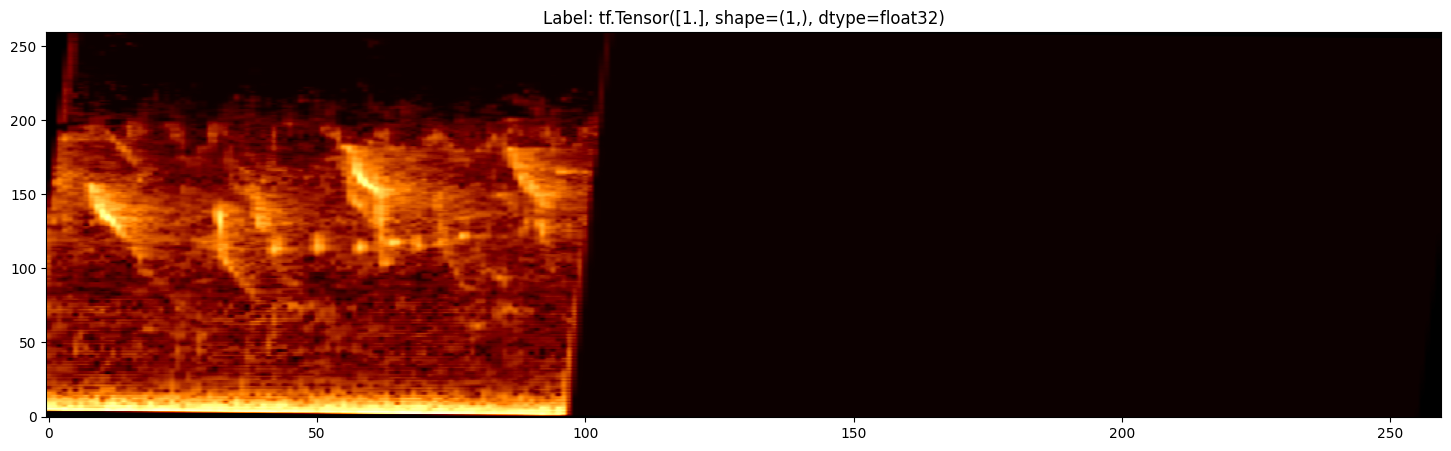

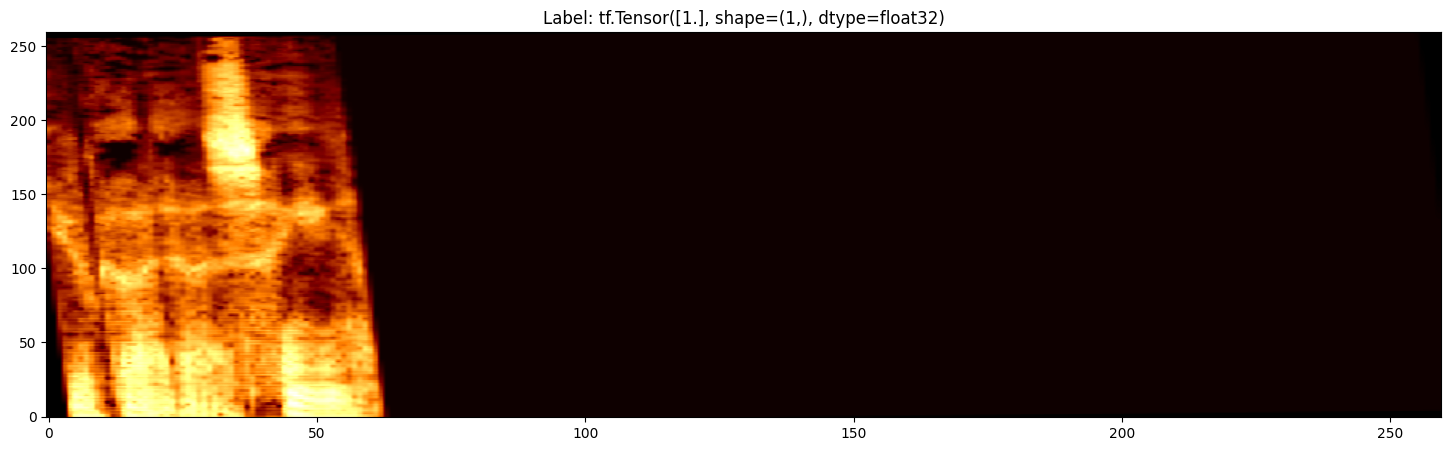

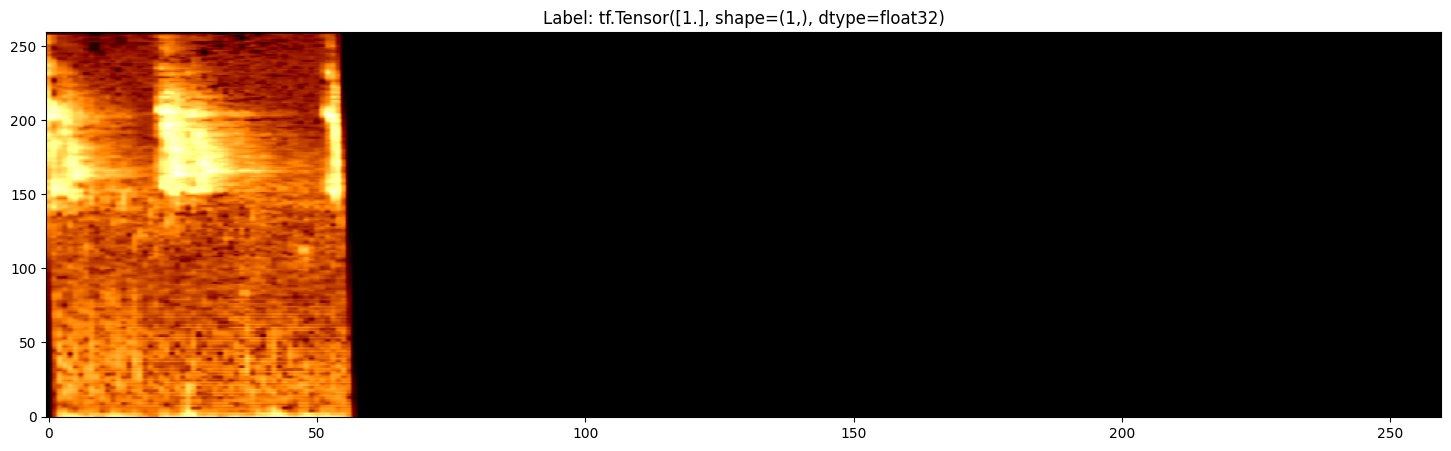

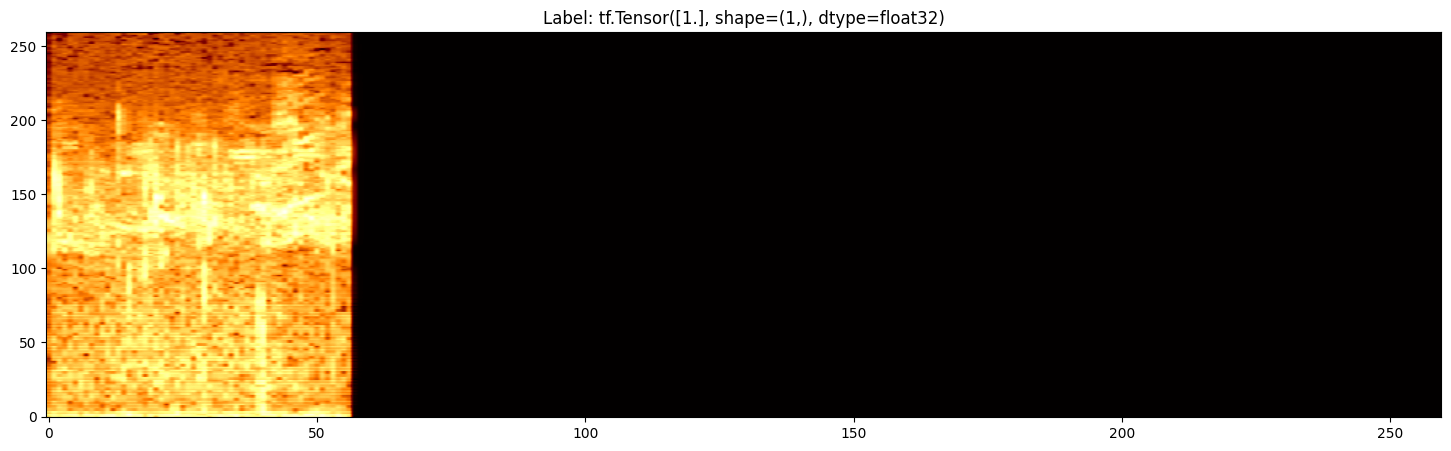

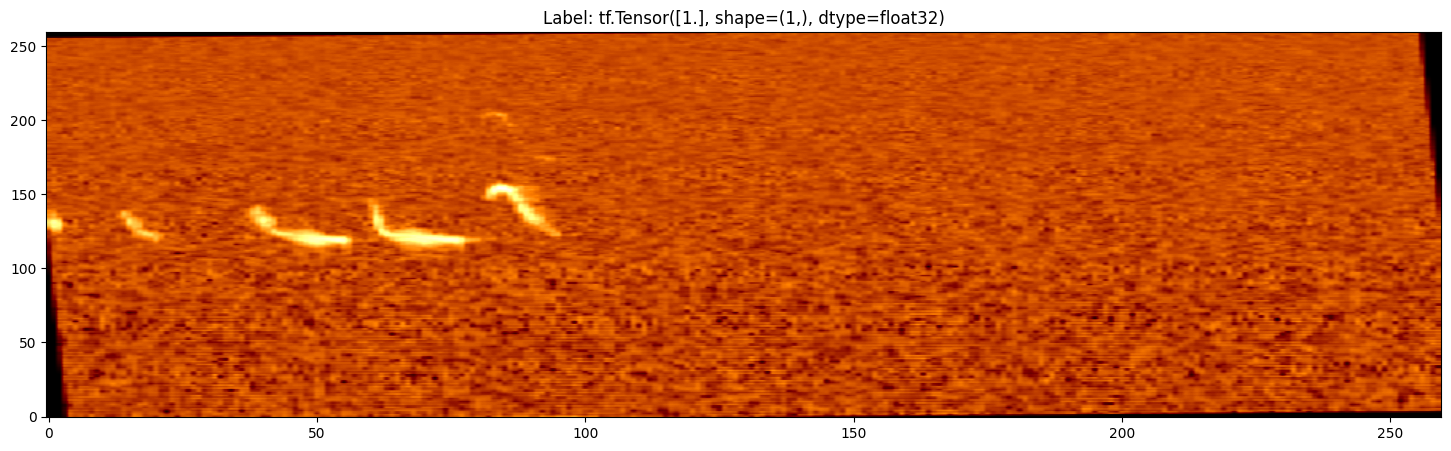

In [59]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

# Classification Model

In order to test whether the pipeline is working a CNN based image classification model is constructed below.  This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image.  Note that on first run this model tensorflow hub library will check if model weights are available, and if not, will automatically download them to your computer.  This may take a few minutes the first time this is run.

The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

In [60]:
def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'],
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'],
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            hub.KerasLayer("https://tfhub.dev/google/bird-vocalization-classifier/1", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None,
                 SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 SC['MODEL_INPUT_IMAGE_WIDTH'],
                 SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [61]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
  ) -> np.ndarray:
    """Helper function for framing audio for inference."""
    if window_size_s is None or window_size_s < 0:
      return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

def ensure_sample_rate(waveform, original_sample_rate,
                       desired_sample_rate=32000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    waveform = tfio.audio.resample(waveform, original_sample_rate, desired_sample_rate)
  return desired_sample_rate, waveform

In [62]:
!curl -O  "/content/drive/MyDrive/Training data/*/*.mp3"
#!curl -O "/content/drive/MyDrive/bird/*.ogg"

import os

# Define the folder containing your audio files
audio_folder = "/content/drive/MyDrive/Training data/"

# Get a list of all files in the folder
audio_files = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith('.mp3')]

if os.path.exists(audio_folder):
  print("The files exist.")
else:
  print("The files does not exist.")

curl: (3) URL using bad/illegal format or missing URL
The files exist.


In [63]:
import os

# Define the directory path you want to process
directory_path = '/content/drive/MyDrive/Training data/'

# Get a list of all items (files and subdirectories) in the directory
items = os.listdir(directory_path)

# Filter out only regular files
regular_files = [item for item in items if os.path.isfile(os.path.join(directory_path, item))]

# Now, 'regular_files' contains a list of regular file names in the directory

# You can loop through regular_files and perform your processing on these files
for file_name in regular_files:
    # Process the file as needed
    file_path = os.path.join(directory_path, file_name)
    # Perform your processing on 'file_path'



# Model Training

The following sets up callbacks to track model training and performs the model fit to train the model.

The callbacks will ensure the best model weights (as defined by lowest validation loss) will be written to disk during training.  This is important as the model training could take several hours (12+ hours) to complete and any errors may cause the training loop to exit - so having the checkpoints acts as a backup.  The model will stop training when it sees no further improvement to the validation loss, after which it will restore the best weights found.  This allows the training to discover when it is overfit and stop further training.  This is why the number of epics is 10000.  It is expected the model training will end significantly earlier than this.

In [64]:
import os
import datetime
import tensorflow as tf
import tensorflow_hub as hub

def build_model(trainable):
    # Load the TensorFlow Hub model without specifying tags
    hub_url = "https://tfhub.dev/google/bird-vocalization-classifier/1"  # Replace with your desired model URL
    hub_model = hub.load(hub_url)

    # Create a Keras Sequential model
    # model = tf.keras.Sequential([
    #     hub_model,
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dense(10, activation='softmax')  # Replace 10 with the number of classes in your problem
    # ])

    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'],
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'],
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
         #   hub.KerasLayer("https://tfhub.dev/google/bird-vocalization-classifier/1", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(class_names), activation=None),
        ]
    )

    return model

if not os.path.exists('models/'):
    os.mkdir('models/')
if not os.path.exists('models/1'):
    os.mkdir('models/1')

# Set trainable to True to allow all the weights to be trained
model = build_model(trainable=True)

# The form_logits means the loss function has the 'softmax' built-in.
# This approach is numerically more stable than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"],
              )


# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.75,
                                                      patience=8,
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0,
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
model.fit(train_dataset,
          validation_data=validation_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=SC['MAX_EPOCHS'])


Epoch 1/5000
36/36 [==============================] - 122s 3s/step - loss: 0.0000e+00 - accuracy: 0.3537 - val_loss: 0.0000e+00 - val_accuracy: 0.1176 - lr: 1.0000e-04
Epoch 2/5000
36/36 [==============================] - 117s 3s/step - loss: 0.0000e+00 - accuracy: 0.3328 - val_loss: 0.0000e+00 - val_accuracy: 0.0882 - lr: 1.0000e-04
Epoch 3/5000
36/36 [==============================] - 108s 3s/step - loss: 0.0000e+00 - accuracy: 0.3432 - val_loss: 0.0000e+00 - val_accuracy: 0.0956 - lr: 1.0000e-04
Epoch 4/5000
36/36 [==============================] - 103s 3s/step - loss: 0.0000e+00 - accuracy: 0.3659 - val_loss: 0.0000e+00 - val_accuracy: 0.1176 - lr: 1.0000e-04
Epoch 5/5000
36/36 [==============================] - 108s 3s/step - loss: 0.0000e+00 - accuracy: 0.3258 - val_loss: 0.0000e+00 - val_accuracy: 0.1544 - lr: 1.0000e-04
Epoch 6/5000
36/36 [==============================] - 98s 3s/step - loss: 0.0000e+00 - accuracy: 0.3206 - val_loss: 0.0000e+00 - val_accuracy: 0.1912 - lr: 1.00

# Model Predictions on test data

The following provides an example of how to use the trained model to perform inference (predictions).  It calculates the best class and the probability for that class.

In [79]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # In a single-class scenario, there's no need for tf.argmax
    predicted_class = class_names[0]  # Use the only class name
    # Calculate the predicted probability (always 100% for single class)
    predicted_probability = 100.0
    return predicted_class, predicted_probability

# Display class name and run prediction on test entries
print(f'Class name: {class_names[0]}')
for features, _ in test_dataset:
    # Generate predictions for the given features
    predictions = model.predict(features, verbose=0)

    # Iterate over each item in the batch (should be 1 item in single-class scenario)
    for batch_idx in range(predictions.shape[0]):
        # Predict class and probability using the simplified function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')


Class name: Acanthagenys rufogularis
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0
Predicted class : Acanthagenys rufogularis
Predicted probability : 100.0


In [80]:
# Save the full model for use with tensorflow serving
model.save('models/echo_model/1/', overwrite=True)